<a href="https://colab.research.google.com/github/msibriani/information_retrieval_eq2/blob/main/Avance4_Equipo2_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

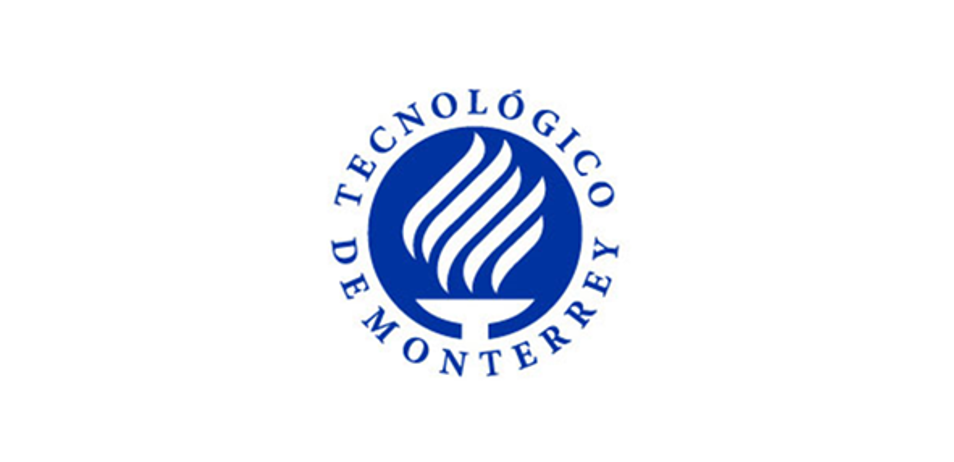

# MNA Maestría en Inteligencia Artificial Aplicada
# MNA Maestría en Inteligencia Artificial Aplicada

###Materia: TC5035.10 Proyecto Integrador
 (Gpo 10)



###Prof. Titulares:
###Dra. Grettel Barceló Alonso
###Dr. Luis Eduardo Falcón Morales



###Avance 4. Otros Modelos.



###EQUIPO 2
###Alumnos - Matrícula
###**Matthias Sibrian Illescas - A01794249**
###**José Ramiro Adán Charles - A00174646**
###**Genaro Ramos Higuera - A00351269**

###Instalamos librerias de trabajo

In [3]:
!pip install haystack-ai
!pip install "sentence-transformers>=2.2.0"
!pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.5/319.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)


Cargamos librerias y definimos los metodos para cargar en memoria los documentos y la conversion de los PDFs

In [5]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
pdf_converter = PyPDFToDocument()


Definimos el metodo para limpiar los documentos

In [6]:
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=200, split_overlap=50)


Agregamos el embedder que utilizaremos en el Pipeline para los documentos que escribiremos en la document store.

In [7]:
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store)


Ahora armamos la secuencia del Pipeline a aplicar a los documentos PDF

In [8]:
preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")


Ahora conectamos el Pipeline:

In [9]:
preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
preprocessing_pipeline.connect("pypdf_converter", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")


🚅 Components
  - file_type_router: FileTypeRouter
  - pypdf_converter: PyPDFToDocument
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pypdf_converter.sources (List[Path])
  - pypdf_converter.documents -> document_cleaner.documents (List[Document])
  - document_cleaner.documents -> document_splitter.documents (List[Document])
  - document_splitter.documents -> document_embedder.documents (List[Document])
  - document_embedder.documents -> document_writer.documents (List[Document])

###Cargamos todos los documentos de la carpeta de PDFs /content/data/pdf
###y aplicamos el Pipeline de preprocesamiento

In [10]:
from pathlib import Path

carpeta_pdfs = "/content/data/pdf"
preprocessing_pipeline.run({"file_type_router": {"sources": list(Path(carpeta_pdfs).glob("**/*"))}})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/149 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 4756}}

Ahora utilizaremos el mismo embedder para las preguntas (questions) y poder hacer la recuperacion mediante el Retriever.

In [11]:
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")


In [12]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

retriever = InMemoryEmbeddingRetriever(document_store)


Ahora definimos el prompt builder para las preguntas y le decimos que tome el contexto de los documentos para generar las respuestas

In [13]:
from haystack.components.builders import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)


Ahora cargamos el API Key para el LLM que utilizaremos:

In [14]:
import os
from getpass import getpass
from haystack.components.generators import OpenAIGenerator

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")
generator = OpenAIGenerator(model="gpt-3.5-turbo")


Enter OpenAI API key:··········


In [15]:
basic_rag_pipeline = Pipeline()
# Adicionamos los componentes al pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Ahora los conectamos dentro del pipeline
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [16]:
question = "¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La definición exacta de un crédito académico en nuestra institución para los 3 niveles es la siguiente:

- Preparatoria: 6 unidades académicas equivalen a 3 créditos académicos.
- Profesional: 8 unidades académicas equivalen a 3 créditos académicos.
- Posgrado: 12 unidades académicas equivalen a 3 créditos académicos.


In [22]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina considerando que un crédito académico representa 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico.


In [17]:
question = "¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo las normativas establecidas por la Dirección de Internacionalización del Tecnológico de Monterrey, así como las disposiciones académicas para programas de internacionalización del Sistema ITESM.


In [18]:
question = "¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para evaluar y asignar créditos a un nuevo curso o programa académico incluye especificar los métodos de evaluación a los participantes, cumplir con los criterios definidos en el reglamento académico para alumnos de programas de posgrado, y asegurarse de que los participantes demuestren logros satisfactorios del programa, concluyan el programa y hayan sido evaluados. Los medios de evaluación pueden variar dependiendo de los objetivos de aprendizaje del programa e incluir exámenes escritos u orales, documentos escritos, observación de desempeño, evaluación de un producto de aprendizaje, entre otros. La calificación obtenida por el estudiante debe ser igual o superior a 80/100 o su equivalente para poder acreditar hasta 36 unidades en un programa de posgrado.


In [19]:
question = "¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, se considera la carga de trabajo fuera del aula, como tareas y proyectos, al asignar créditos académicos. Los créditos académicos representan tanto la asistencia a las horas-clase como el tiempo dedicado al trabajo independiente del alumno, lo cual se tiene en cuenta al determinar la carga académica de cada unidad de formación.


In [21]:
question = "¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante para determinar el número de créditos de un curso se calcula asignando un determinado número de unidades a cada curso, de forma que el total de unidades de los cursos que integran un semestre sea similar a los de un semestre de los planes de estudio de profesional, maestría y doctorado. Esto se realiza tomando en cuenta el número de horas totales de trabajo que el curso demande a los alumnos.


In [20]:
question = "¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

A los estudiantes se les comunica la cantidad de créditos de cada curso y la expectativa de trabajo asociada a través de la definición de un crédito académico, que consiste en 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, totalizando 54 horas durante el periodo académico. Además, se establece que cada unidad de formación tiene 2 créditos y se describen las horas de dedicación total de cada crédito. También se menciona la carga académica de tiempo completo de un estudiante por periodo regular y la diferencia en créditos para periodo intensivo.


In [23]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional mediante la inclusión de la traducción de la escala de calificaciones de las universidades extranjeras a su equivalente en el Sistema Tecnológico de Monterrey en todos los convenios. Además, se establecen criterios claros para la asignación de calificaciones y la conversión de créditos académicos, asegurando que los alumnos sean informados antes de su partida sobre estos aspectos.


In [24]:
question = "Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para la transferencia de créditos de otras instituciones implica que las horas de trabajo correspondientes a los cursos pueden estimarse en horas-crédito por semestre de acuerdo con ciertos criterios establecidos. Por ejemplo, se establece que a una hora de clase por semana de un curso semestral le corresponde una hora-crédito por semestre. Además, se menciona que las instituciones pueden aceptar los créditos obtenidos en programas de Credenciales Alternativas de Posgrado en el Tecnológico de Monterrey, aunque la aceptación siempre es determinada por la institución educativa en la que se solicite la acreditación. Es importante cumplir con la normativa establecida para dichas acreditaciones para asegurar la equivalencia de créditos.


In [25]:
question = "¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos son unidades de medida que representan el tiempo y esfuerzo que un estudiante dedica a una materia o unidad de formación. Estos créditos son esenciales para el progreso y la planificación académica de los estudiantes, ya que permiten determinar la carga académica que deben asumir en cada semestre y el total de créditos necesarios para completar satisfactoriamente un plan de estudios.

Además, los créditos académicos son utilizados para comparar la carga de trabajo entre diferentes niveles educativos, como preparatoria, profesional y posgrado. Esto garantiza que los programas de estudio tengan una estructura equilibrada y comparable en cuanto a la cantidad de trabajo requerido para completarlos.

En resumen, los créditos académicos son una herramienta fundamental en la gestión del progreso académico de los estudiantes, permitiendo una planificación efectiva de sus horarios, asignaturas a cursar y el tiempo necesario para completar sus estudios de manera exitosa.


In [26]:
question = "¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan de manera periódica, ya que se menciona que se realizan cambios y actualizaciones en los reglamentos académicos y que se publicarán en la próxima edición de las Políticas y Normas Académicas Generales. Además, se menciona una actualización en la definición de crédito académico en posgrado, lo que indica que se revisan y actualizan conforme sea necesario.


In [27]:
question = "¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se utilizan los siguientes criterios para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso:

1. Los créditos académicos de una unidad de formación representan el tiempo de trabajo que un alumno dedica a la unidad de formación para cumplir con los objetivos del mismo.
2. Se asigna un determinado número de créditos académicos a cada unidad de formación, de forma que el total de créditos académicos en las unidades de formación que integran un semestre sea similar a los de un semestre de los planes de estudio de profesional, maestría y doctorado.


In [28]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según la información proporcionada, la distribución de horas en el cálculo de un crédito académico es la siguiente: 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo cual suma un total de 54 horas durante el periodo académico.


Ahora probamos con el LLM Mistral mistralai/Mixtral-8x7B-Instruct-v0.1

In [35]:
from haystack.components.generators import HuggingFaceAPIGenerator

if "HF_API_TOKEN" not in os.environ:
    os.environ["HF_API_TOKEN"] = getpass("Enter Hugging Face token:")
generator =HuggingFaceAPIGenerator(api_type="serverless_inference_api", api_params={"model": "mistralai/Mixtral-8x7B-Instruct-v0.1"})

In [36]:
question = "¿Cuál es la definición exacta de un crédito académico en nuestra institución para los 3 niveles Preparatoria, Profesional y Posgrado?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La definición exacta de un crédito académico en nuestra institución para los 3 niveles es la siguiente:

- Preparatoria: 6 unidades académicas equivalen a 3 créditos académicos.
- Profesional: 8 unidades académicas equivalen a 3 créditos académicos.
- Posgrado (planes versión anterior a 2024): 12 unidades académicas equivalen a 3 créditos académicos.


In [37]:
question = "2. ¿Cómo se determina la equivalencia de un crédito académico en términos de horas de trabajo del estudiante (lecturas, prácticas, estudio independiente, etc.)?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La equivalencia de un crédito académico en términos de horas de trabajo del estudiante se determina en base a 120 horas para tres créditos académicos, lo que equivale a la suma de las horas clase y las horas de trabajo independiente. Para un crédito académico, se consideran 40 horas, que también incluyen las horas clase y las horas de trabajo independiente.


In [38]:
question = "¿Qué normativas nacionales o internacionales estamos siguiendo para la asignación de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo las normativas establecidas por la Dirección de Internacionalización y el Reglamento para la Gestión y Operación de Programas Internacionales del Tecnológico de Monterrey. Además, también se hace referencia a los convenios de cooperación académica internacional establecidos por el Sistema ITESM.


In [40]:
uestion = "¿Cuál es el proceso para evaluar y asignar créditos a un nuevo curso o programa académico?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Estamos siguiendo las normativas establecidas por el Tecnológico de Monterrey en relación con los convenios de cooperación académica internacional, así como las disposiciones académicas para programas de internacionalización del Sistema ITESM.


In [41]:
question = "¿Se considera la carga de trabajo fuera del aula (como tareas y proyectos) al asignar créditos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sí, se considera la carga de trabajo fuera del aula, como tareas y proyectos, al asignar créditos académicos. El tiempo dedicado por los estudiantes tanto en clase como en actividades independientes es tomado en cuenta para determinar la cantidad de créditos asignados a cada unidad de formación.


In [42]:
question = "¿Cómo se calcula la carga de trabajo del estudiante para determinar el número de créditos de un curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

La carga de trabajo del estudiante para determinar el número de créditos de un curso se calcula asignando un determinado número de horas de trabajo por semana a cada curso. Esto se hace de manera que el total de unidades de los cursos que integran un semestre de un plan de estudios sea similar a los de un semestre de otros programas académicos. Además, se pueden estimar las horas de trabajo en horas-crédito por semestre, de acuerdo con ciertas equivalencias establecidas en las políticas y normas académicas del Tecnológico de Monterrey.


In [43]:
question = "¿De qué manera se comunica a los estudiantes la información sobre la cantidad de créditos de cada curso y la expectativa de trabajo asociada?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

A los estudiantes se les comunica que cada unidad de formación tiene asignados 2 créditos y que la definición de un crédito académico implica 15 horas de sesiones con el profesor más 39 horas de trabajo independiente del estudiante, lo que suma un total de 54 horas durante el periodo académico. Además, se les informa sobre la carga académica de tiempo completo y la cantidad de créditos que pueden tomar por periodo regular o intensivo, así como los estándares de dedicación por crédito para los cursos intensivos. También se les indica que al concluir satisfactoriamente una Credencial Alternativa, obtendrán una constancia o certificado del Tecnológico de Monterrey. Toda esta información les permite a los estudiantes comprender la cantidad de trabajo asociado a cada curso y la importancia de los créditos en su carga académica.


In [44]:
question = "9. ¿Cómo se garantiza la comparabilidad de nuestros créditos académicos con los de otras instituciones a nivel nacional e internacional?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se garantiza la comparabilidad de los créditos académicos con otras instituciones a nivel nacional e internacional mediante la traducción de la escala de calificaciones a su equivalente en el Sistema Tecnológico de Monterrey, la cual es una acción obligatoria para todos los convenios con universidades extranjeras. Además, la asignación de calificaciones y la conversión de los créditos académicos se hace de acuerdo con lo establecido en cada convenio, asegurando así que los créditos sean reconocidos de manera equitativa y objetiva.


In [45]:
question = "Cuál es el proceso para la transferencia de créditos de otras instituciones y cómo se asegura su equivalencia?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

El proceso para la transferencia de créditos de otras instituciones en el Tecnológico de Monterrey implica que las horas de trabajo correspondientes a los cursos puedan estimarse en horas-crédito por semestre. Esto se realiza dividiendo el total de unidades del curso entre cuatro para cursos de posgrado semestrales, o dividiendo entre cuatro y multiplicando por 0.75 para cursos trimestrales debido a la diferencia en la duración de los períodos académicos. Además, se debe garantizar que la suma de las horas de trabajo y las horas clase sea equivalente a la carga académica del Tecnológico de Monterrey, asegurando así la equivalencia de los créditos obtenidos en otras instituciones.


In [46]:
question = "¿Cómo influyen los créditos académicos en el progreso y la planificación académica de los estudiantes?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Los créditos académicos son importantes para el progreso y la planificación académica de los estudiantes ya que representan el tiempo que un alumno dedica a una materia o unidad de formación, tanto dentro como fuera del salón de clases, para alcanzar los objetivos de aprendizaje establecidos. Los créditos académicos permiten a los estudiantes llevar un registro de su avance en el plan de estudios, ya que cada materia o unidad de formación tiene asignado un determinado número de créditos. Además, los créditos académicos son utilizados para determinar la carga académica que un estudiante puede manejar en un periodo específico, ya sea normal o intensivo, lo que ayuda en la organización y distribución de las materias a lo largo de su carrera. También, los créditos académicos son fundamentales para la transferencia de estudiantes entre programas o instituciones, ya que facilitan la comparación de los cursos y la equivalencia de contenidos en diferentes contextos educativos. En resumen, los 

In [47]:
question = "¿Con qué frecuencia se revisan y actualizan las políticas de créditos académicos?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Las políticas de créditos académicos se revisan y actualizan de forma periódica, con cambios que se implementan a partir de ciertas fechas especificadas en los documentos proporcionados. Por ejemplo, se menciona que a partir de enero de 2024 se implementará de manera gradual la transición a la unidad de medida de "Créditos Académicos" en los programas académicos. Además, se menciona que se realizan actualizaciones en la definición de crédito académico en programas de Posgrado, excluyendo especialidades médicas, lo que indica una revisión continua de las políticas en esta área.


In [48]:
question = "¿Qué criterios se utilizan para actualizar la asignación de créditos en respuesta a cambios en el contenido del curso?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Se utilizan criterios como la carga académica de tiempo completo del estudiante por periodo regular, el número de créditos reprobados, el estatus académico del alumno, y los resultados de las unidades de formación cursadas por los alumnos.


In [49]:
question = "14. El crédito académico representa las horas de dedicación de un alumno en un curso bajo supervisión de un profesor y actividades independientes, ¿cuál es la distribución de horas en el cálculo de un crédito?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Según la información proporcionada, la distribución de horas en el cálculo de un crédito académico es la siguiente:

- 15 horas de sesiones con el profesor.
- 39 horas de trabajo independiente del estudiante.
- Total de 54 horas durante el periodo académico.
